In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2015,2018 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# NEXRAD Level 3 File

Use MetPy to read information from a NEXRAD Level 3 (NIDS product) file and plot

In [3]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from metpy.calc import azimuth_range_to_lat_lon
from metpy.cbook import get_test_data
from metpy.io import Level3File
from metpy.plots import add_metpy_logo, add_timestamp, colortables, USCOUNTIES
from metpy.units import units

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


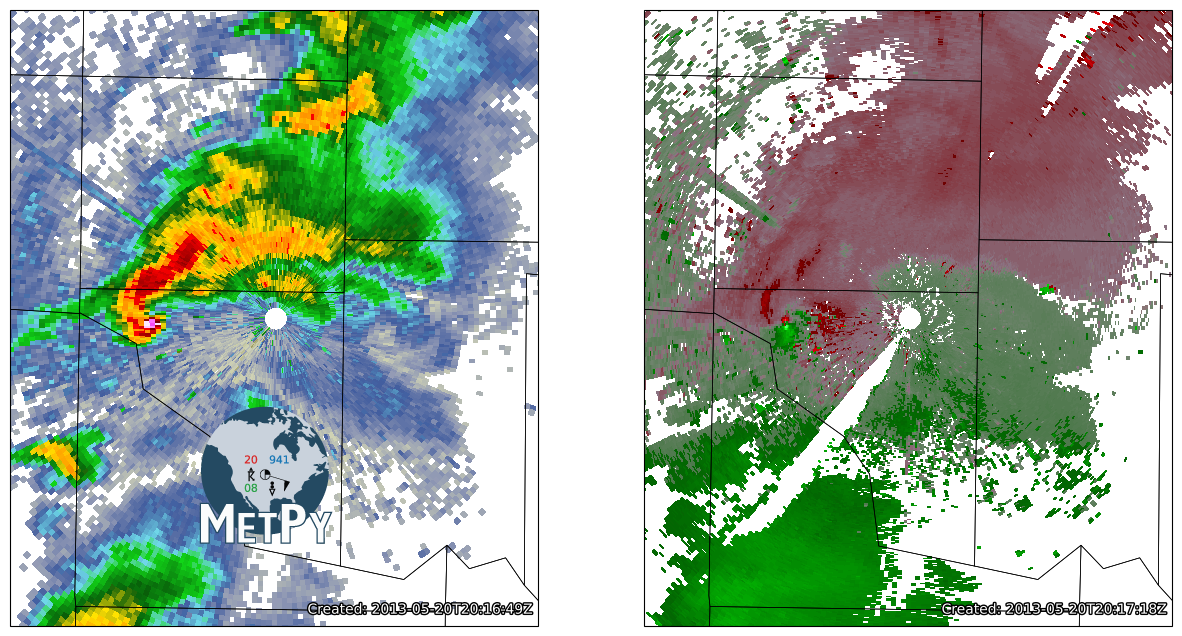

In [4]:
spec = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(15, 8))
add_metpy_logo(fig, 190, 85, size='large')
ctables = (('NWSStormClearReflectivity', -20, 0.5),  # dBZ
           ('NWS8bitVel', -100, 1.0))  # m/s

for v, ctable, ax_rect in zip(('N0Q', 'N0U'), ctables, spec, strict=False):
    # Open the file
    name = get_test_data(f'nids/KOUN_SDUS54_{v}TLX_201305202016', as_file_obj=False)
    f = Level3File(name)

    # Pull the data out of the file object
    datadict = f.sym_block[0][0]

    # Turn into an array using the scale specified by the file
    data = f.map_data(datadict['data'])

    # Grab azimuths and calculate a range based on number of gates,
    # both with their respective units
    az = units.Quantity(np.array(datadict['start_az'] + [datadict['end_az'][-1]]), 'degrees')
    rng = units.Quantity(np.linspace(0, f.max_range, data.shape[-1] + 1), 'kilometers')

    # Extract central latitude and longitude from the file
    cent_lon = f.lon
    cent_lat = f.lat

    # Convert az,range to x,y
    xlocs, ylocs = azimuth_range_to_lat_lon(az, rng, cent_lon, cent_lat)

    # Plot the data
    crs = ccrs.LambertConformal()
    ax = fig.add_subplot(ax_rect, projection=crs)
    ax.add_feature(USCOUNTIES, linewidth=0.5)
    norm, cmap = colortables.get_with_steps(*ctable)
    ax.pcolormesh(xlocs, ylocs, data, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
    ax.set_extent([cent_lon - 0.5, cent_lon + 0.5, cent_lat - 0.5, cent_lat + 0.5])
    ax.set_aspect('equal', 'datalim')
    add_timestamp(ax, f.metadata['prod_time'], y=0.02, high_contrast=True)

plt.show()